In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

Collect and preprocessing the data

In [2]:
gefcom = pd.read_csv("Data/GEFCOM_fixed.txt", sep="\s+", names = ["Date", "Hour", "Price", "System_load", "Zonal_load", "Day_of_week"])

<>:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_2807/2169693869.py:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  gefcom = pd.read_csv("Data/GEFCOM_fixed.txt", sep="\s+", names = ["Date", "Hour", "Price", "System_load", "Zonal_load", "Day_of_week"])


In [3]:
# Check variables types
gefcom.dtypes

Date           float64
Hour           float64
Price          float64
System_load    float64
Zonal_load     float64
Day_of_week    float64
dtype: object

In [4]:
# Change Date column to datetime type
gefcom["Date"] = pd.to_datetime(gefcom["Date"], format="%Y%m%d")

In [5]:
gefcom.describe()

,Date,Hour,Price,System_load,Zonal_load,Day_of_week
count,25968,25968.00000,25968.000000,25968.000000,25968.000000,25968.000000
mean,2012-06-24 12:00:00,11.50000,48.190072,18165.881200,6105.779767,4.000000
min,2011-01-01 00:00:00,0.00000,12.520000,11544.000000,3395.000000,1.000000
25%,2011-09-28 00:00:00,5.75000,33.470000,15620.000000,5131.000000,2.000000
50%,2012-06-24 12:00:00,11.50000,42.870000,18069.000000,6076.000000,4.000000
75%,2013-03-22 00:00:00,17.25000,54.300000,19858.250000,6714.000000,6.000000
max,2013-12-17 00:00:00,23.00000,363.800000,33449.000000,11441.000000,7.000000
std,NaN,6.92232,26.179381,3453.664269,1309.476852,2.002348


In [6]:
# Check NA values
gefcom.isna().sum()

Date           0
Hour           0
Price          0
System_load    0
Zonal_load     0
Day_of_week    0
dtype: int64

In [7]:
# Check for dupplicates 
gefcom.duplicated().sum()

np.int64(0)

In [8]:
# Check unique hours
gefcom["Hour"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [9]:
# Check if price for each record > 0
(gefcom["Price"] <= 0).sum()

np.int64(0)

In [10]:
# Create a new column with log price
gefcom["Log_price"] = np.log(gefcom["Price"])
gefcom

,Date,Hour,Price,System_load,Zonal_load,Day_of_week,Log_price
0,2011-01-01,0.0,43.17,15187.0,5091.0,6.0,3.765146
1,2011-01-01,1.0,36.24,14464.0,4918.0,6.0,3.590163
2,2011-01-01,2.0,34.64,13940.0,4763.0,6.0,3.545009
3,2011-01-01,3.0,33.76,13609.0,4660.0,6.0,3.519277
4,2011-01-01,4.0,33.08,13391.0,4599.0,6.0,3.498929
...,...,...,...,...,...,...,...
25963,2013-12-17,19.0,113.92,23091.0,7167.0,2.0,4.735496
25964,2013-12-17,20.0,107.26,22504.0,6958.0,2.0,4.675256
25965,2013-12-17,21.0,89.02,21538.0,6707.0,2.0,4.488861
25966,2013-12-17,22.0,85.40,20025.0,6316.0,2.0,4.447346


# Model building

- ARX: 
$$p_{d,h} = \beta_{0} + \beta_{1p_{d-1,h}} + \beta_{2p_{d-2,h}} + \beta_{3p_{d-7,h}} + \beta_{4p_{min,d-1}} + \beta_{5z_{d}} + \sum \beta_{D} D_{d} + \epsilon_{d,h}$$

In [11]:
# Create log price lags
gefcom["p_lag1"] = gefcom["Log_price"].shift(24)
gefcom["p_lag2"] = gefcom["Log_price"].shift(48)
gefcom["p_lag7"] = gefcom["Log_price"].shift(168)

daily_min = gefcom.groupby("Date")["Log_price"].min().shift(1) 
gefcom = gefcom.merge(daily_min.rename("min_price"), on="Date")

gefcom["Log_system_load"] = np.log(gefcom["System_load"])

# Create dummies
gefcom["D_1"] = (gefcom["Day_of_week"] == 1).astype(int)
gefcom["D_6"] = (gefcom["Day_of_week"] == 6).astype(int)
gefcom["D_7"] = (gefcom["Day_of_week"] == 7).astype(int)

In [12]:
gefcom = gefcom[7*24:].reset_index(drop=True)

In [13]:
# Set the split date
## In the article: train: 2011-01-01 -> 2012-12-28, test: 2012-12-29 -> 2013-12-17
split_date = pd.Timestamp("2012-12-29")

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_2807/3024055652.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


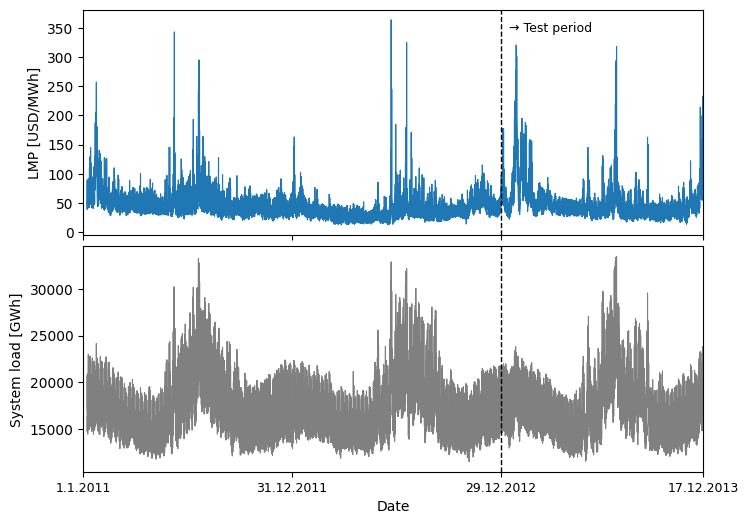

In [14]:
# Define key dates
x_ticks = [
    pd.Timestamp("2011-01-01"),
    pd.Timestamp("2011-12-31"),
    pd.Timestamp("2012-12-29"),
    pd.Timestamp("2013-12-17")
]

x_labels = ["1.1.2011", "31.12.2011", "29.12.2012", "17.12.2013"]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.05})

# --- Top panel: Prices
ax1.plot(gefcom["Date"], gefcom["Price"], color="tab:blue", linewidth=0.8)
ax1.set_ylabel("LMP [USD/MWh]", fontsize=10)

# --- Bottom panel: System Load
ax2.plot(gefcom["Date"], gefcom["System_load"], color="gray", linewidth=0.8)
ax2.set_ylabel("System load [GWh]", fontsize=10)
ax2.set_xlabel("Date", fontsize=10)

# --- Set x-axis limits to data range (no empty space)
xmin = gefcom["Date"].min()
xmax = gefcom["Date"].max()
ax1.set_xlim(xmin, xmax)

# --- Set x-axis ticks and labels
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, fontsize=9)

# --- Add one continuous dashed vertical line for the test period
for ax in [ax1, ax2]:
    ax.axvline(split_date, color="k", linestyle="--", linewidth=1)

# Add annotation
ax1.text(split_date + pd.Timedelta(days=15), 350, "→ Test period", fontsize=9, va="center")

plt.tight_layout()
plt.show()

In [ ]:
# --- podział na zbiór treningowy i testowy ---
train = gefcom[gefcom["Date"] < split_date].reset_index(drop=True)
test = gefcom[gefcom["Date"] >= split_date].reset_index(drop=True)

# --- przygotowanie danych globalnie ---
windows_length = range(28, 729, 1)
hours = range(24)
X_cols = ["p_lag1", "p_lag2", "p_lag7", "min_price", "Log_system_load", "D_1", "D_6", "D_7"]

# dzień numeryczny (liczba dni od początku) – kluczowe do poprawnego T
gefcom["day_id"] = (gefcom["Date"] - gefcom["Date"].min()).dt.days
test["day_id"] = (test["Date"] - gefcom["Date"].min()).dt.days

# dane w formacie NumPy
hours_all = gefcom["Hour"].values
day_ids_all = gefcom["day_id"].values
X_all = gefcom[X_cols].to_numpy(dtype=float)
y_all = gefcom["Log_price"].to_numpy(dtype=float)

test_hours = test["Hour"].values
test_day_ids = test["day_id"].values
test_X = test[X_cols].to_numpy(dtype=float)

# --- prosta funkcja OLS ---
def fit_ols(X, y):
    X_ols = np.hstack([np.ones((X.shape[0], 1)), X])
    beta, *_ = np.linalg.lstsq(X_ols, y, rcond=None)
    return beta

def predict_ols(X, beta):
    X_ols = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_ols @ beta

def run_hour_for_window(T, h):
    mask_h = hours_all == h
    X_h = X_all[mask_h]
    y_h = y_all[mask_h]
    day_h = day_ids_all[mask_h]

    mask_test_h = test_hours == h
    X_test_h = test_X[mask_test_h]
    test_day_h = test_day_ids[mask_test_h]

    preds = np.full(mask_test_h.sum(), np.nan)
    unique_days = np.unique(test_day_h)

    for d_day in unique_days:
        mask_cal = (day_h >= d_day - T) & (day_h < d_day)
        if np.count_nonzero(mask_cal) < 10:
            continue

        X_train = X_h[mask_cal]
        y_train = y_h[mask_cal]

        valid = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
        if not np.any(valid):
            continue

        X_train = X_train[valid]
        y_train = y_train[valid]

        mask_test_day = test_day_h == d_day
        X_test_valid = X_test_h[mask_test_day]
        valid_fut = ~np.isnan(X_test_valid).any(axis=1)
        if not np.any(valid_fut):
            continue

        X_test_valid = X_test_valid[valid_fut]

        beta = fit_ols(X_train, y_train)
        preds_day = predict_ols(X_test_valid, beta)
        preds[mask_test_day] = preds_day

    return h, preds


results_ARX = []
for T in tqdm(windows_length, desc="Window length (ARX)"):
    predictions = np.full(len(test), np.nan)

    outputs = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_hour_for_window)(T, h) for h in hours
    )

    for h, preds_h in outputs:
        mask_test_h = test["Hour"].values == h
        predictions[mask_test_h] = preds_h

    results_ARX.append({"T": T, "Predictions": predictions})

Window length (NARX):   0%|          | 2/701 [02:06<12:28:38, 64.26s/it]/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user

KeyboardInterrupt: 

In [ ]:

y_true = test["Price"].to_numpy()
results_mae = []

for r in results_ARX:
    T = r["T"]
    pred_log = r["Predictions"]

    mask = ~np.isnan(pred_log) & ~np.isnan(y_true)
    pred_price = np.exp(pred_log)
    mae = np.mean(np.abs(y_true[mask] - pred_price[mask]))

    results_mae.append({"T": T, "MAE": mae})

Win_T = pd.DataFrame(results_mae).sort_values("T").reset_index(drop=True)

KeyError: 'T'

In [ ]:
T_all = list(range(28, 729, 28))
set_defs = {
    "AW(364,728)": [364, 728],
    "AW(28:728)": list(range(28, 729, 1)),
    "AW(28:7:728)": list(range(28, 729, 7)),
    "AW(28:14:728)": list(range(28, 729, 14)),
    "AW(28:28:728)": list(range(28, 729, 28)),
    "AW(28,728)": [28, 728],
    "AW(56,728)": [56, 728],
    "AW(28:28:84,714:7:728)": list(range(28, 85, 28)) + list(range(714, 729, 7)),
    "AW(28,56,728)": [28, 56, 728],
    "AW(28,56,364,728)": [28, 56, 364, 728],
    "AW(28,56,721,728)": [28, 56, 721, 728],
}

# zestawy symetryczne
S_sizes = [2, 4, 6, 8, 10, 12]
for s in S_sizes:
    half = s // 2
    left = T_all[:half]
    right = T_all[-half:]
    set_defs[f"AW_S{s}"] = left + right

pred_dict_ARX = {r["T"]: r["Predictions"] for r in results_ARX}

In [ ]:
def compute_aw_mae(pred_dict, Tset, name, y_true):
    preds_log_list = [pred_dict[T] for T in Tset if T in pred_dict]
    preds_price_mat = np.vstack([np.exp(p) for p in preds_log_list])
    preds_price_avg = np.nanmean(preds_price_mat, axis=0)

    mask = ~np.isnan(preds_price_avg) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - preds_price_avg[mask]))

    return {"Name": name, "Size": len(Tset), "MAE": mae, "Tset": Tset}

In [ ]:
aw_rows = []
for name, Tset in set_defs.items():
    aw_rows.append(compute_aw_mae(pred_dict_ARX, Tset, name, y_true))

AW = pd.DataFrame(aw_rows).sort_values("MAE").reset_index(drop=True)

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_4031/2774171026.py:9: RuntimeWarning: Mean of empty slice
  preds_price_avg = np.nanmean(preds_price_mat, axis=0)
/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/igamoskwa/Desktop/PredictiveAnalyticsProject/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
Win_T

,T,MAE
0,28,7.422864
1,29,7.324881
2,30,7.301913
3,31,7.332054
4,32,7.314449
...,...,...
696,724,6.993085
697,725,6.990461
698,726,6.987910
699,727,6.981621


In [ ]:
AW

,Name,Size,MAE,Tset
0,"AW(28,56,721,728)",4,6.565728,"[28, 56, 721, 728]"
1,AW_S4,4,6.567532,"[28, 56, 700, 728]"
2,"AW(28,56,364,728)",4,6.592724,"[28, 56, 364, 728]"
3,"AW(28:28:84,714:7:728)",6,6.617863,"[28, 56, 84, 714, 721, 728]"
4,AW_S6,6,6.622005,"[28, 56, 84, 672, 700, 728]"
5,"AW(28,728)",2,6.636545,"[28, 728]"
6,AW_S2,2,6.636545,"[28, 728]"
7,AW_S8,8,6.690976,"[28, 56, 84, 112, 644, 672, 700, 728]"
8,AW_S10,10,6.736086,"[28, 56, 84, 112, 140, 616, 644, 672, 700, 728]"
9,AW_S12,12,6.762298,"[28, 56, 84, 112, 140, 168, 588, 616, 644, 672..."


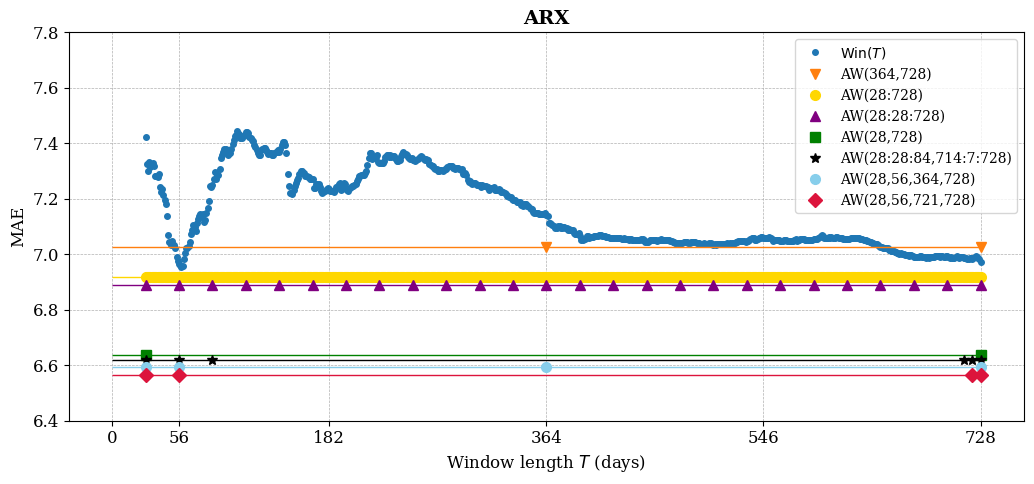

In [ ]:
# --- Styl jak w artykule ---
mpl.rc('font', family='serif', size=12)
mpl.rc('text', usetex=False)

plot_order = [
    ("AW(364,728)", "v", "tab:orange"),
    ("AW(28:728)", "o", "gold"),
    ("AW(28:28:728)", "^", "purple"),
    ("AW(28,728)", "s", "green"),
    ("AW(28:28:84,714:7:728)", "*", "black"),
    ("AW(28,56,364,728)", "o", "skyblue"),
    ("AW(28,56,721,728)", "D", "crimson"),
    ("AW_S2", "P", "tab:brown"),
    ("AW_S4", "X", "tab:olive"),
    ("AW_S6", ">", "tab:gray"),
    ("AW_S8", "<", "tab:pink"),
    ("AW_S10", "p", "tab:cyan"),
    ("AW_S12", "H", "tab:red"),
]

fig, axes = plt.subplots(2, 1, figsize=(11, 9), sharex=True, gridspec_kw={'hspace': 0.15})

models = ["ARX", "NARX"]
colors = {"ARX": "tab:blue", "NARX": "tab:red"}

for ax, model_name in zip(axes, models):
    # Win(T)
    ax.plot(Win_T[model_name]["T"], Win_T[model_name]["MAE"],
            "o", color=colors[model_name], markersize=4,
            label=fr"$\mathrm{{Win}}(T)$ - {model_name}")

    # Wszystkie zestawy (łącznie z AW_S)
    for (name, marker, color) in plot_order:
        row = AW[model_name][AW[model_name]["Name"] == name]
        if row.empty:
            continue
        mae = row["MAE"].values[0]
        ax.hlines(mae, xmin=0, xmax=728, colors=color, linestyles="-", linewidth=1)
        x_points = np.array(set_defs[name])
        y_points = np.full_like(x_points, mae, dtype=float)
        ax.plot(x_points, y_points, marker=marker, color=color,
                linestyle="None", markersize=7, label=name)

    ax.set_ylabel("MAE", fontsize=11)
    ax.set_ylim([6.4, 7.8])
    ax.set_title(f"{model_name} model", fontweight="bold", fontsize=14)
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Legenda przesunięta na prawo
    ax.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1), frameon=True)

axes[-1].set_xlabel("Window length $T$ (days)")
axes[-1].set_xticks([0, 56, 182, 364, 546, 728])

plt.tight_layout()
plt.show()

In [ ]:
# --- Oblicz % zmianę względem Win(728) dla obu modeli ---
AW_sorted = {}

for model in ["ARX", "NARX"]:
    baseline_T = 728
    baseline_mae = Win_T[model].loc[Win_T[model]["T"] == baseline_T, "MAE"].values[0]

    df = AW[model].copy()
    df["Delta_log_vs_Win728"] = np.log(baseline_mae / df["MAE"])
    df["Pct_change_vs_Win728"] = (baseline_mae / df["MAE"] - 1) * 100

    df = df.sort_values("Pct_change_vs_Win728", ascending=False).reset_index(drop=True)
    AW_sorted[model] = df[["Name", "MAE", "Pct_change_vs_Win728"]]

,Name,MAE,Pct_change_vs_Win728
0,"AW(28,56,721,728)",6.565728,6.168410
1,AW_S4,6.567532,6.139242
2,"AW(28,56,364,728)",6.592724,5.733668
3,"AW(28:28:84,714:7:728)",6.617863,5.332022
4,AW_S6,6.622005,5.266141
5,"AW(28,728)",6.636545,5.035512
6,AW_S2,6.636545,5.035512
7,AW_S8,6.690976,4.181055
8,AW_S10,6.736086,3.483381
9,AW_S12,6.762298,3.082257
